In [ ]:
import pandas as pd
import numpy as np
import os, sys
import random
import pickle

import matplotlib.pyplot as plt
import copy
from collections import Counter
import warnings

sys.path.insert(0, '/nas/longleaf/home/smerrill/evolution/')
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
warnings.filterwarnings("ignore")

## This Notebook Is for Plotting OOD PR Curves for Various Fitness Functions
- It first requires running cheating_analysis.py

### 1.  Helper functions
- NOTE: get_results_df may require some subtle tweaks based on how you save the files so take caution here

In [2]:
def get_plot(ax, pool_precision, pool_recall, recalls_df, precisions_df, best_fitness_index, title):
    # Plotting all Random's
    for i in range(recalls_df.shape[1]):
        recall = recalls_df.iloc[:, i].values
        precision = precisions_df.iloc[:, i].values
        ax.plot(recall, precision, marker='+', c='gray', alpha=0.1)
        if i > 1000:
            break

    # Plot full
    ax.plot(pool_recall,
            pool_precision,
            marker='+',
            c='red',
            label='Model Pool')

    try:
        # Plot the best fitness found for each fitness function
        for key, value in best_fitness_index.items():
            ax.plot(recalls_df.iloc[:, value].values,
                    precisions_df.iloc[:, value].values,
                    marker='+',
                    label=key)
    except:
        pass
    
    ax.set_xticks(np.arange(0, 1.01, step=0.1))
    ax.set_xticks(np.arange(0, 1.01, step=0.05), minor=True)
    ax.set_yticks(np.arange(0.6, 1.01, step=0.05))
    ax.set_ylim(0.6, 1.01)
    ax.grid(True, which='both')
    ax.set_title(title)
    #ax.legend(loc='best')

    return ax

def add_difference_cols(results_df2, cols_to_diff):
    results_df = copy.deepcopy(results_df2)
    start_cols = results_df.columns
    for col in cols_to_diff:
        new_cols = [x for x in start_cols if col in x]
        replace_string =  '_' + col.split('_')[-1]
        orig_cols = [x.replace(replace_string, '') for x in copy.deepcopy(new_cols)]
        
        for i in range(len(orig_cols)-1, -1, -1):
            if orig_cols[i] not in results_df.columns:
                print(orig_cols[i])
                del new_cols[i]
                del orig_cols[i]
        
        diff_cols = [x + '_diff' for x in copy.deepcopy(new_cols)]    
        #print(results_df[new_cols])
        results_df[diff_cols] = (results_df[orig_cols].values - results_df[new_cols].values)
        results_df[diff_cols] = results_df[diff_cols].values/results_df[orig_cols].values
        results_df[diff_cols] = results_df[diff_cols].fillna(0)
    return results_df

def get_results_df(save_path):
    exps = os.listdir(save_path)
    exps.sort()
    
    # concatonte all resutls_df
    results_df = pd.DataFrame()
    precisions_df = pd.DataFrame()
    recalls_df = pd.DataFrame()
    for exp in exps:
        try:
            precs = pd.read_csv(save_path + f'/{exp}/precisions_df.csv', header=None).drop(columns=[0]).iloc[1:]
            recs = pd.read_csv(save_path + f'/{exp}/recalls_df.csv', header=None).drop(columns=[0]).iloc[1:]
            result = pd.read_csv(save_path + f'/{exp}/results_df.csv').drop(columns='Unnamed: 0')

            if precs.shape[1] != recs.shape[1]:
                print(save_path + f'/{exp}')
                continue
                
            if result.shape[0] != recs.shape[1]:
                print(results_df.shape, recs.shape)
                continue
                
            precisions_df = pd.concat([precisions_df, precs], axis=1)
            recalls_df = pd.concat([recalls_df,  recs], axis=1)
            results_df = pd.concat([results_df,  result])

        except Exception as e:
            print(e)
            
    recalls_df.columns = [x for x in range(len(recalls_df.columns))]
    precisions_df.columns = [x for x in range(len(precisions_df.columns))]
    
    results_df = results_df.fillna(0)
    results_df = results_df.loc[:, (results_df.sum(axis=0) != 0)]
    
    for col in results_df.columns:
        try:
            results_df[col] = results_df[col].astype(float)
        except ValueError:
            results_df.drop(columns=[col], inplace=True)

    cols_to_diff = ['noise', # these will actually update all columns at begining of loop
                'corrupt',# but these will be corrected as we iterate over list
                'val_id_noise', 
               'val_id_corrupt', ]
               #'val_ood_noise',
               #'val_ood_corrupt']

    results_df = add_difference_cols(results_df, cols_to_diff)
    return results_df, precisions_df, recalls_df

### 2. Load Data

In [3]:
datasets = ['adult_tf', 'heloc_tf', 'compas', 'german']
save_path = '/proj/mcavoy_lab/data/evo_models/exps/cheating_fitness_0802_EOD/'

dataset_precisions = {}
dataset_results = {}
dataset_recalls = {}

for i, dataset in enumerate(datasets):

    # load datasets
    if dataset not in dataset_precisions.keys():
        #precisions_df = pd.read_csv(save_path + f'{dataset}/0/precisions_df.csv', header=None).drop(columns=[0]).iloc[1:]
        #recalls_df = pd.read_csv(save_path + f'{dataset}/0/recalls_df.csv', header=None).drop(columns=[0]).iloc[1:]

        results_df, precisions_df, recalls_df = get_results_df(save_path + f'{dataset}')
        
        dataset_precisions[dataset] = precisions_df
        dataset_recalls[dataset] = recalls_df
        dataset_results[dataset] = results_df.reset_index(drop=True)
        del results_df, precisions_df, recalls_df

/proj/mcavoy_lab/data/evo_models/exps/cheating_fitness_0802_EOD/german/6
min_std_mmd_val_id
min_mmd_val_id
min_std_mmd_val_id
min_mmd_val_id


### 3. Plot Single Name Fitness Functions
- top_n: is the top fitness functions to plot
- metrics is a list of tuples where the element 0 of the tuple is the fitness metric, and element 1 of the tuple is max or min (are we maximizing or minimizing this fitness function)

In [28]:
top_n = 3
metrics = [['ensemble_auc', 'max'],
           ['ensemble_logisticR_train_auc', 'max'],
           ['ensemble_logisticR_train_precision', 'max']]

<Figure size 2000x1200 with 0 Axes>

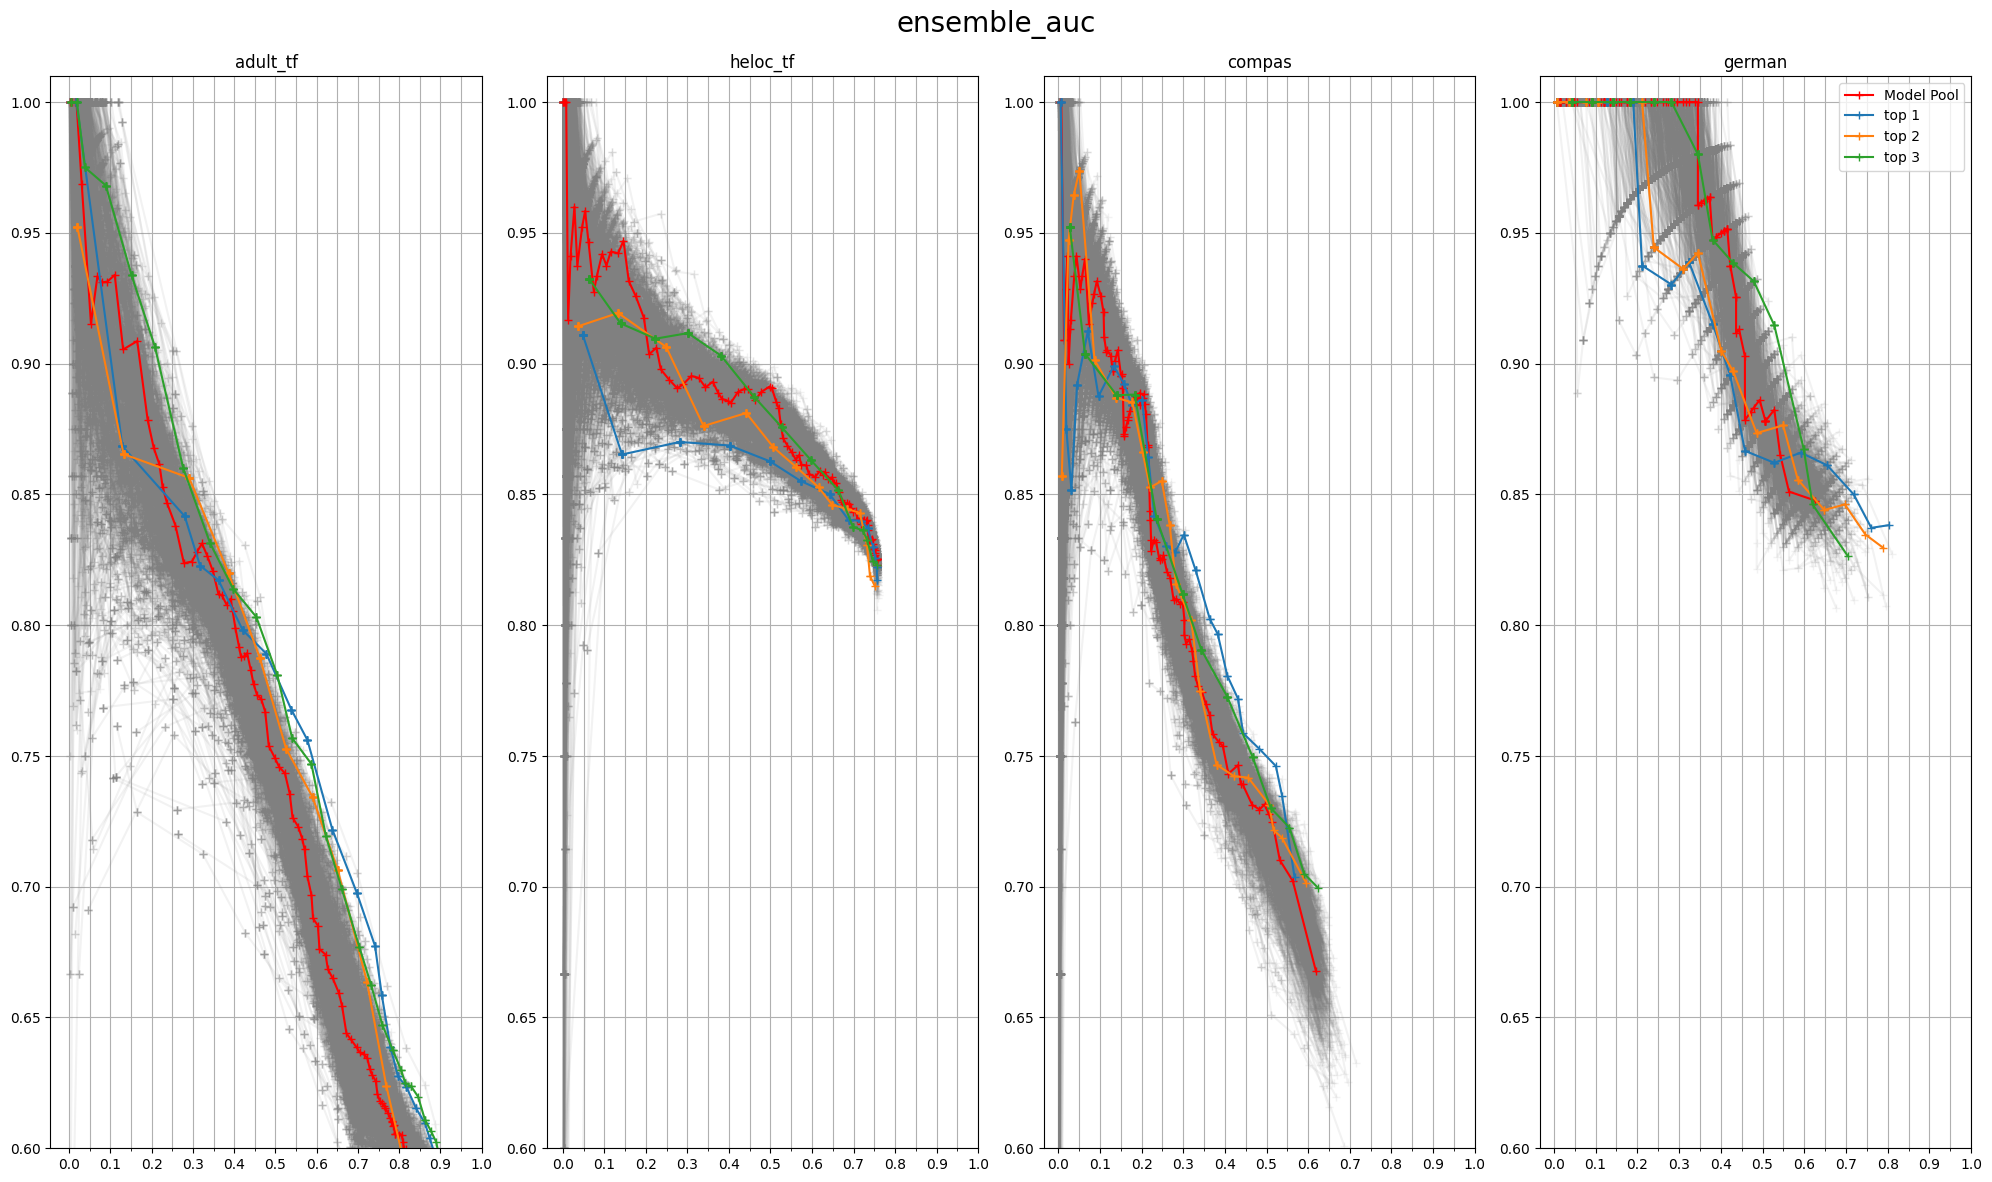

<Figure size 640x480 with 0 Axes>

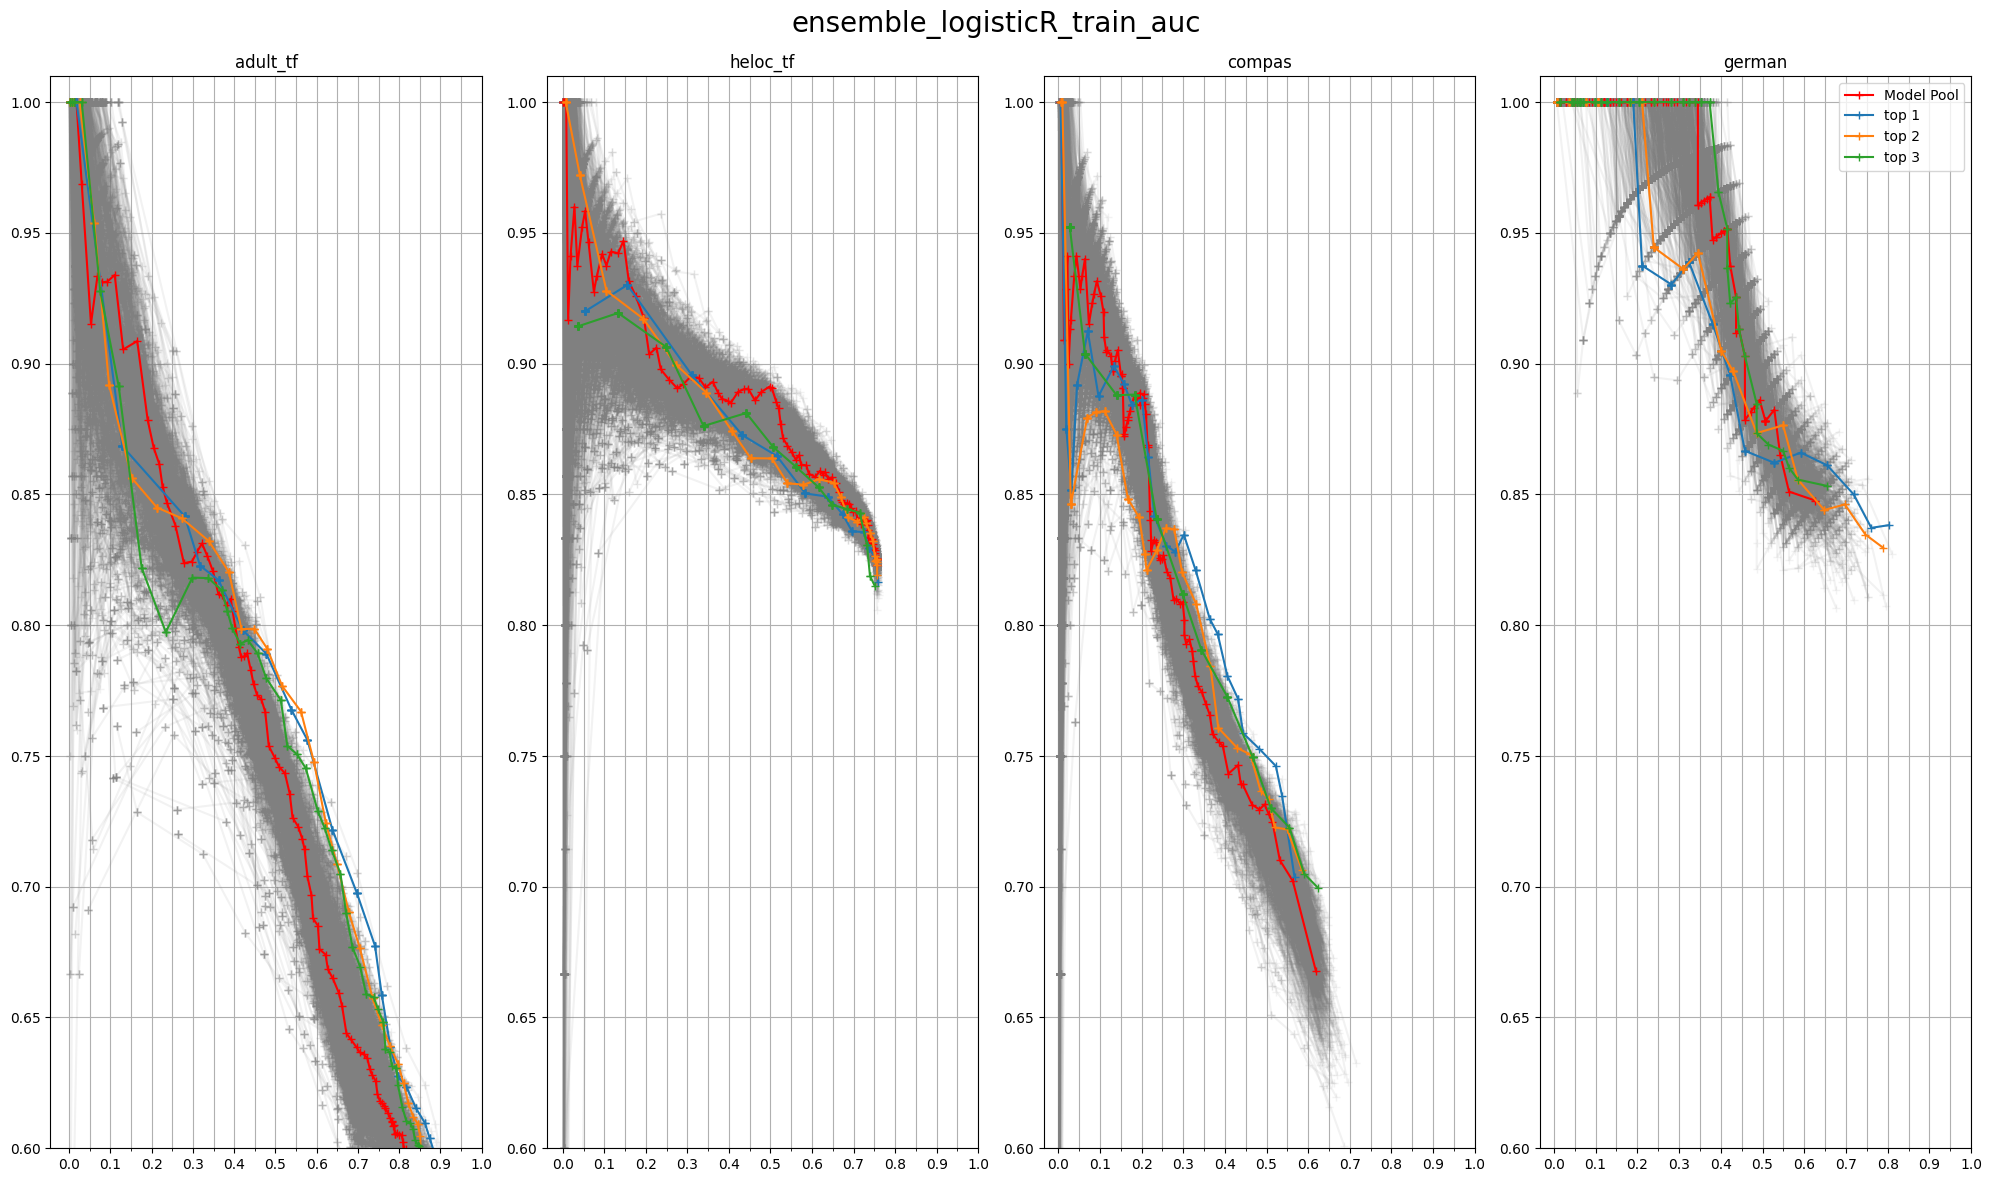

<Figure size 640x480 with 0 Axes>

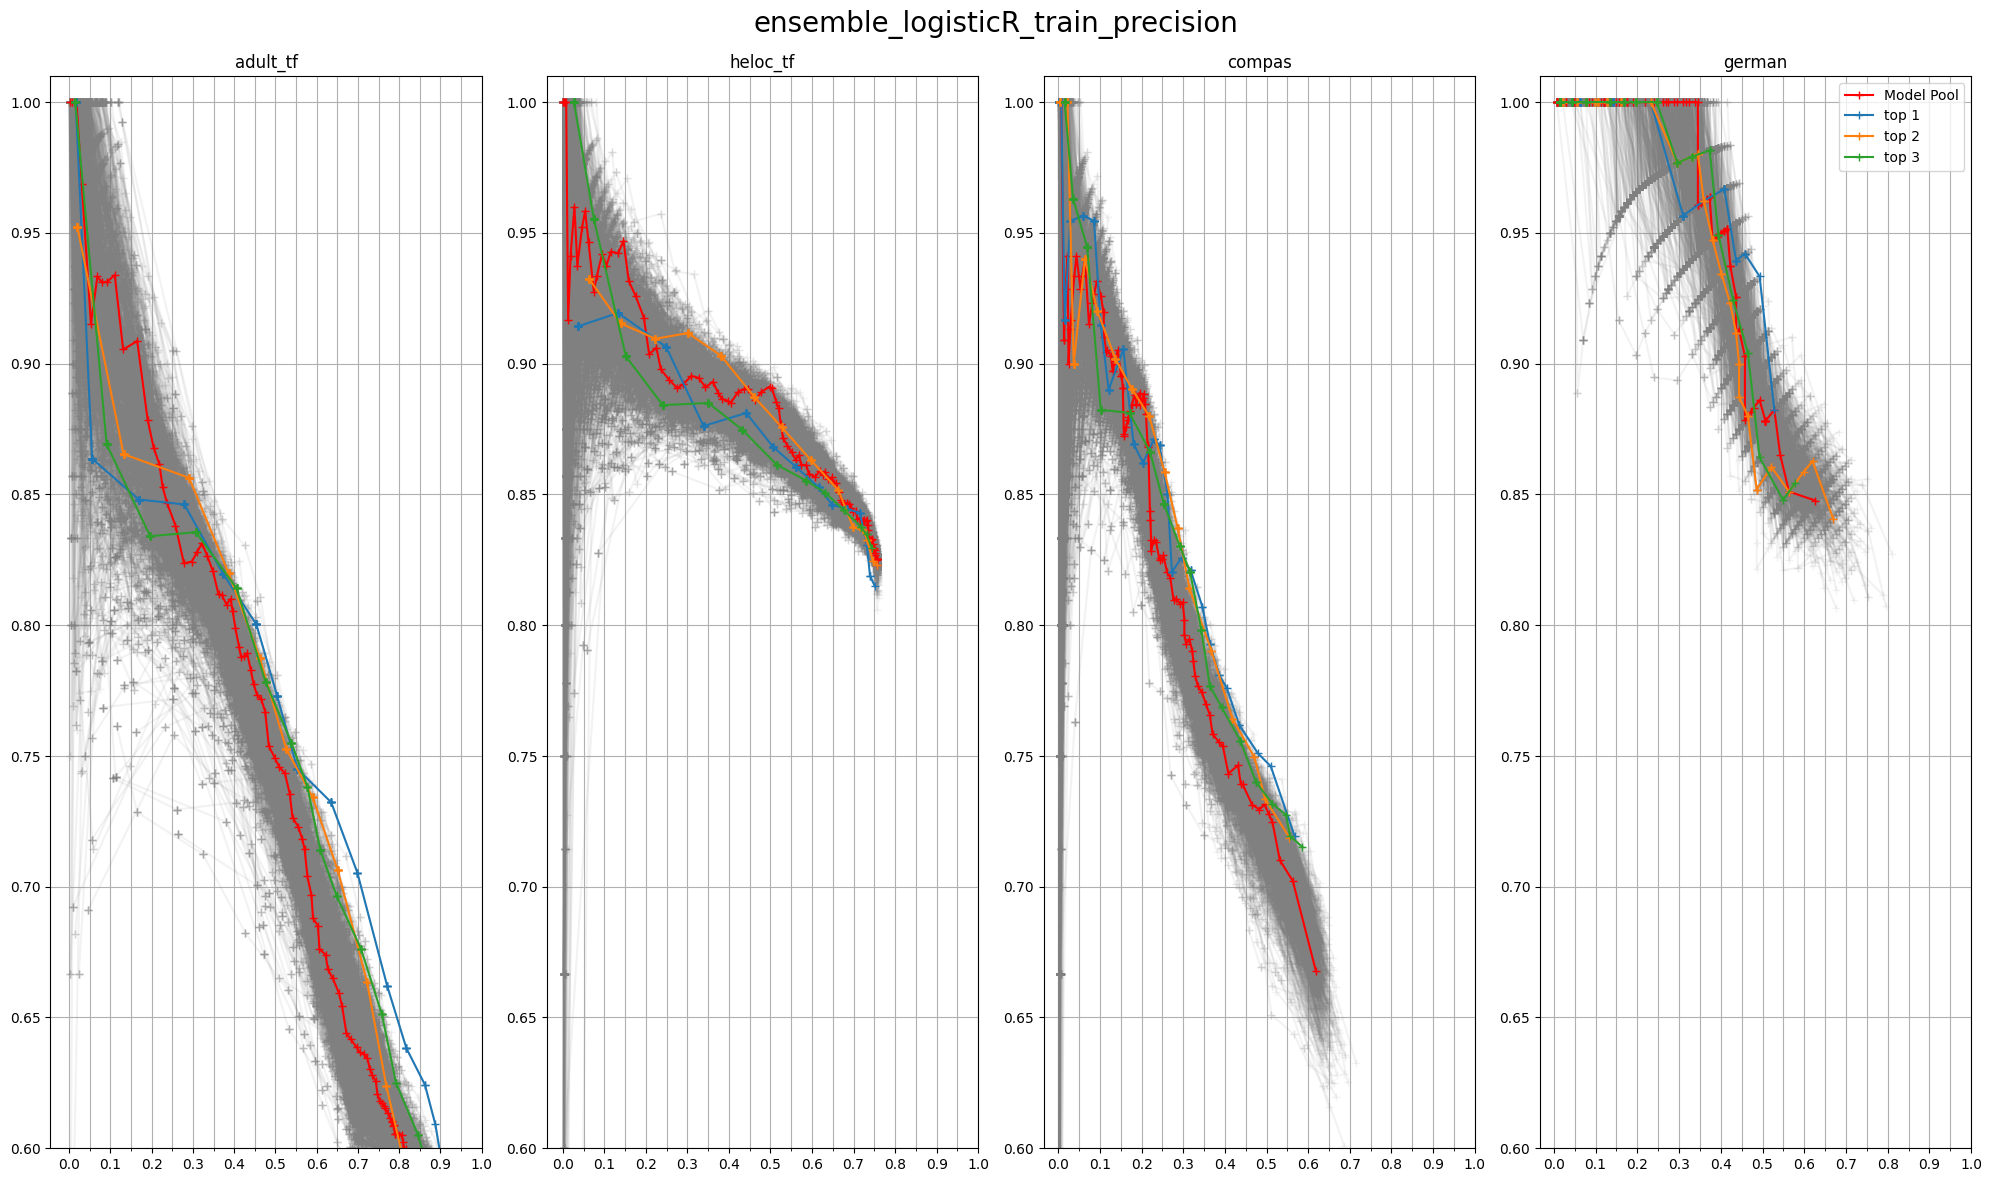

In [29]:
fig, axes = plt.subplots(1, len(datasets), sharey=False, figsize=(20, 12))

for metric, direction in metrics:
    plt.clf()
    fig, axes = plt.subplots(1, len(datasets), sharey=False, figsize=(20, 12))       
    for i, dataset in enumerate(datasets):
        if isinstance(metric, list):
            # take the mean of the list and use that
            dataset_results[dataset]['metric'] = dataset_results[dataset][metric].mean(axis=1).values
            metric_name = 'metric'
        else:
            metric_name = metric
            
        with open(save_path + f'{dataset}/0/model_pool_precision.pkl', 'rb') as file:
            model_pool_precision = pickle.load(file)
        with open(save_path + f'{dataset}/0/model_pool_recall.pkl', 'rb') as file:
            model_pool_recall = pickle.load(file)

        if direction == 'max':
            best_metric = dataset_results[dataset][metric_name].nlargest(top_n).index
        else:
            best_metric = dataset_results[dataset][metric_name].nsmallest(top_n).index
            
        best_fitness_index = {f'top {x+1}':best_metric[x] for x in range(top_n)}


        axes[i] = get_plot(axes[i], 
                           model_pool_precision,
                           model_pool_recall,
                           dataset_recalls[dataset],
                           dataset_precisions[dataset],
                           best_fitness_index,
                           datasets[i])

    plt.legend(loc='best')
    plt.tight_layout(pad=1)
    plt.subplots_adjust(top=0.925) 
    fig.suptitle(metric, fontsize=20)
    plt.show()

### 4. Column Averaging
- This section tries to average multiple fitness functions
- The column averaging.py script defines an evolutionary algorithm to try to search for optimal combinations of fitness functions
- The evo algo tries to optimize the OOD (cheating) precision@k.  The precision@k of the fitness function is averaged over 4 datasets.
- The algo produces output_df.csv

In [30]:
three_cols = pd.read_csv('/proj/mcavoy_lab/data/evo_models/exps/column_avg_main/6/output_df.csv')
three_cols.drop_duplicates(subset='best_ind').nlargest(2, 'score')['best_names'].values

array(["['ensemble_oob_precision_val_id_noise', 'ensemble_logisticR_train_auc_val_id', 'ensemble_logisticR_train_auc_val_id_corrupt']",
       "['ensemble_oob_precision', 'ensemble_logisticR_train_auc_val_id', 'ensemble_logisticR_train_auc_val_id_corrupt']"],
      dtype=object)

In [31]:
four_cols = pd.read_csv('/proj/mcavoy_lab/data/evo_models/exps/column_avg_main/4/output_df.csv')
four_cols.drop_duplicates(subset='best_ind').nlargest(2, 'score')['best_names'].values

array(["['ensemble_logisticR_val_precision_val_id_corrupt', 'ensemble_logisticR_train_auc_val_id_noise', 'ensemble_auc_val_id', 'ensemble_both_acc_val_id_noise_diff']",
       "['ensemble_logisticR_val_precision', 'ensemble_logisticR_train_auc_val_id_noise', 'ensemble_auc_val_id', 'ensemble_both_acc_val_id_noise_diff']"],
      dtype=object)

In [32]:
five_cols = pd.read_csv('/proj/mcavoy_lab/data/evo_models/exps/column_avg_main/5/output_df.csv')
five_cols.drop_duplicates(subset='best_ind').nlargest(2, 'score')['best_names'].values

array(["['ensemble_max_confidence', 'min_std_model_agreement_val_id_corrupt_diff', 'max_training_data', 'ensemble_auc', 'ensemble_oob_auc_val_id']",
       "['ensemble_max_confidence', 'min_std_model_agreement_val_id_corrupt_diff', 'max_training_data', 'ensemble_auc', 'ensemble_oob_acc_val_id_corrupt_diff']"],
      dtype=object)

### 5. Ploting combinations of Fitness Functions
- metrics is still list of tuples, however the first element of the tuple consists of all the fitness functions we want to be averaged

In [34]:
top_n = 3
metrics = [(['ensemble_max_confidence', 'min_std_model_agreement_val_id_corrupt_diff', 'max_training_data', 'ensemble_auc', 'ensemble_oob_auc_val_id'], 'max'),
           (['ensemble_logisticR_val_precision', 'ensemble_logisticR_train_auc_val_id_noise', 'ensemble_auc_val_id', 'ensemble_both_acc_val_id_noise_diff'], 'max'),
           (['ensemble_oob_precision_val_id_noise', 'ensemble_logisticR_train_auc_val_id', 'ensemble_logisticR_train_auc_val_id_corrupt'], 'max')]

<Figure size 2000x1200 with 0 Axes>

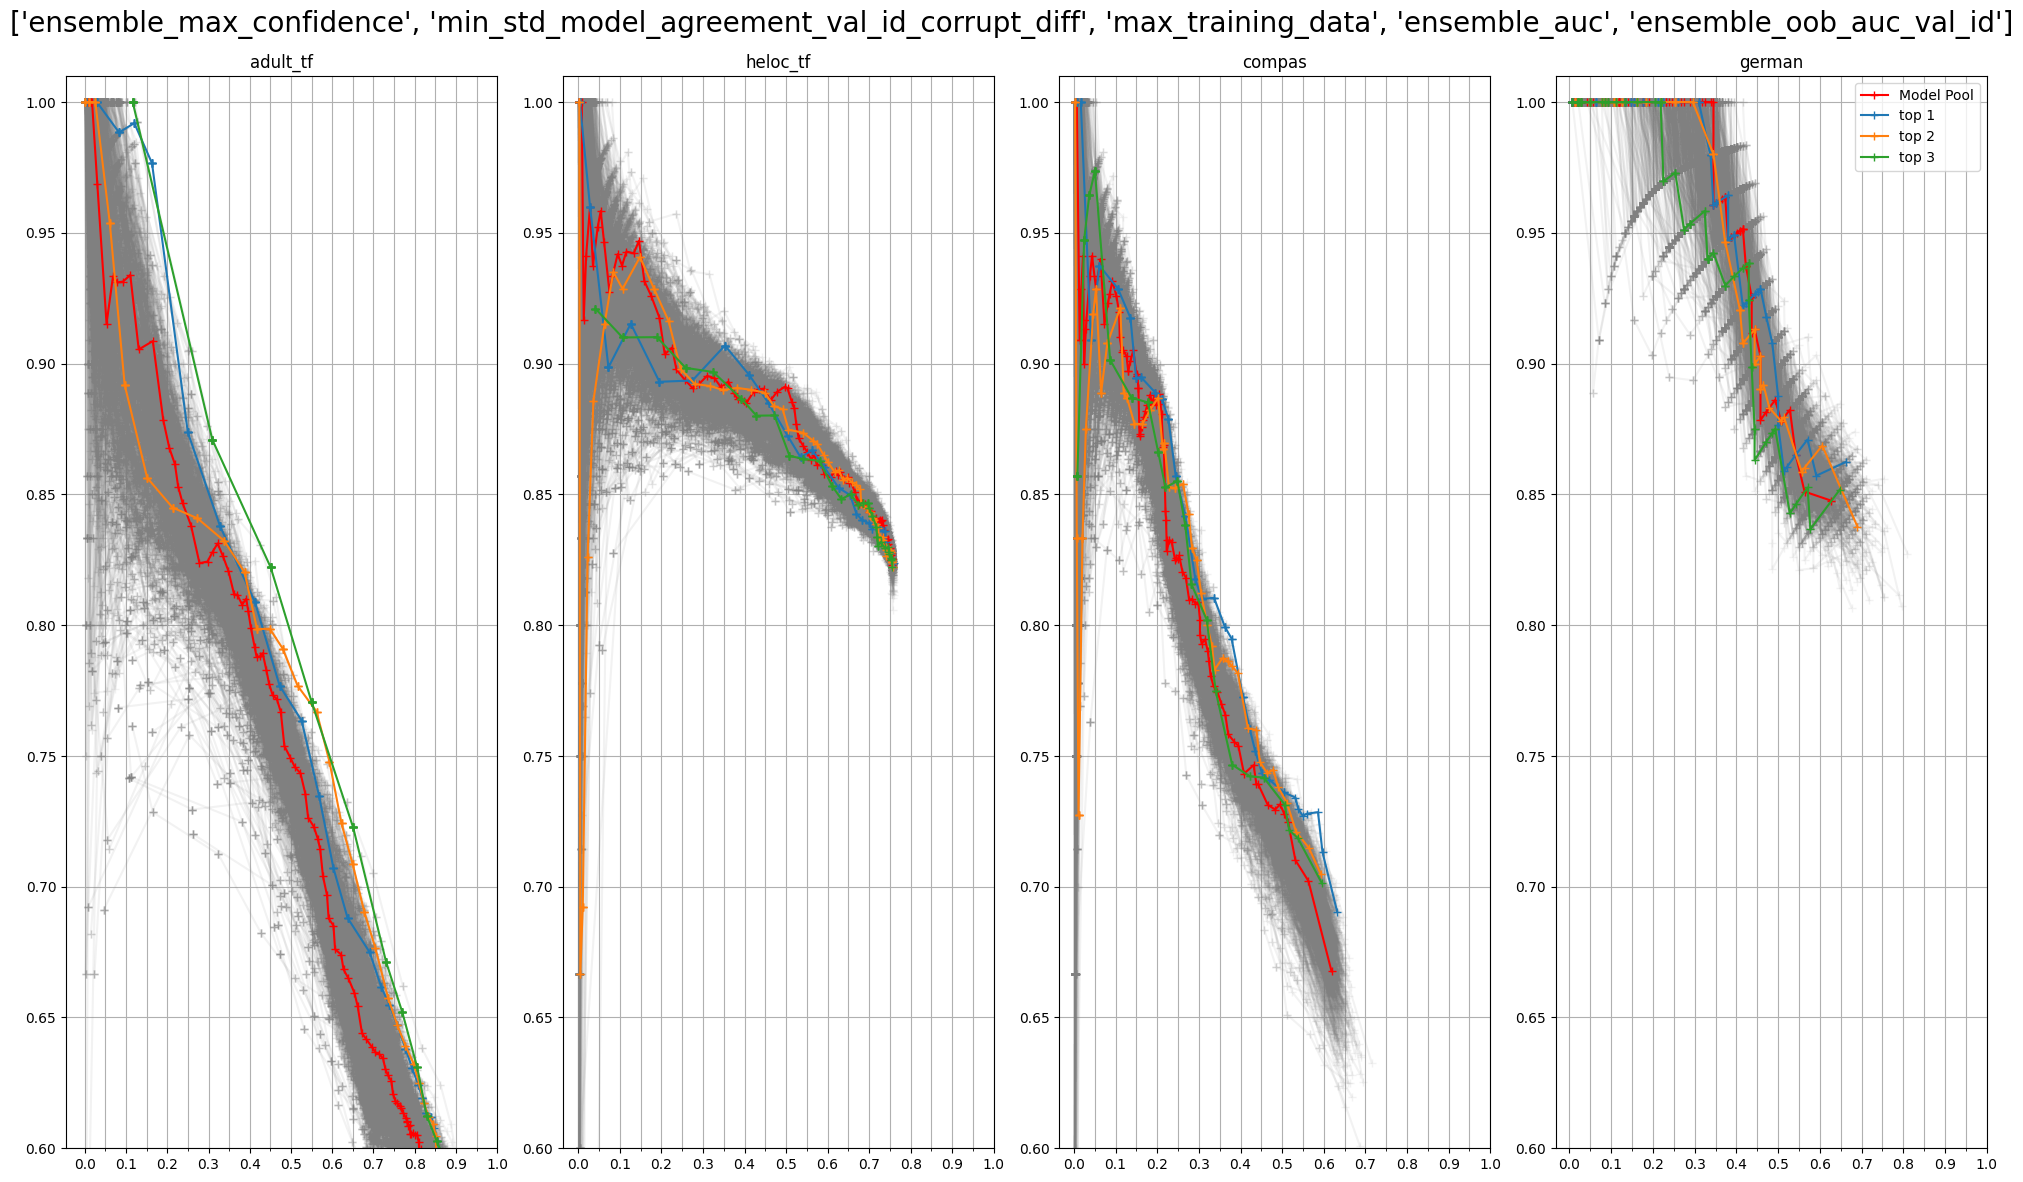

<Figure size 640x480 with 0 Axes>

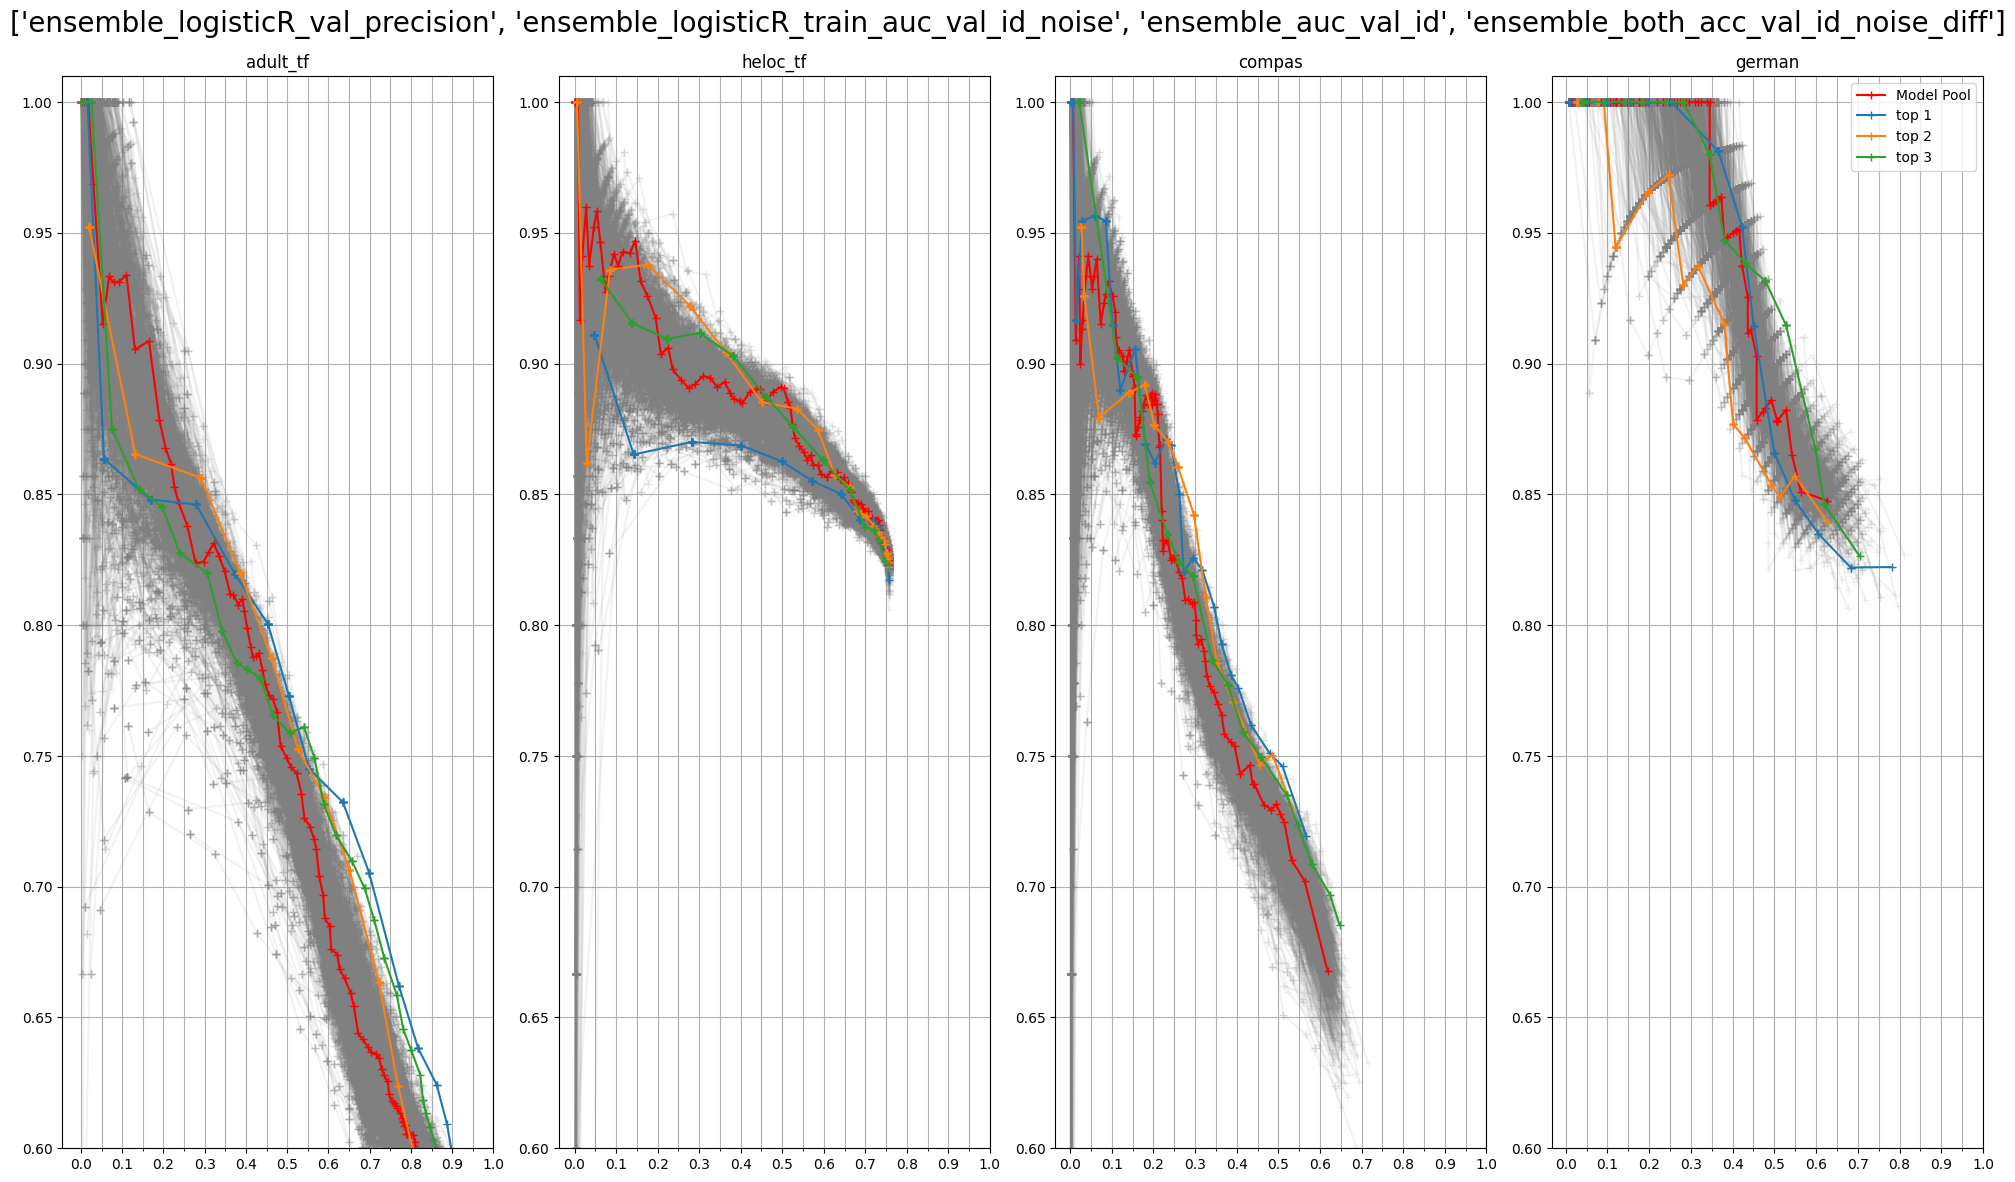

<Figure size 640x480 with 0 Axes>

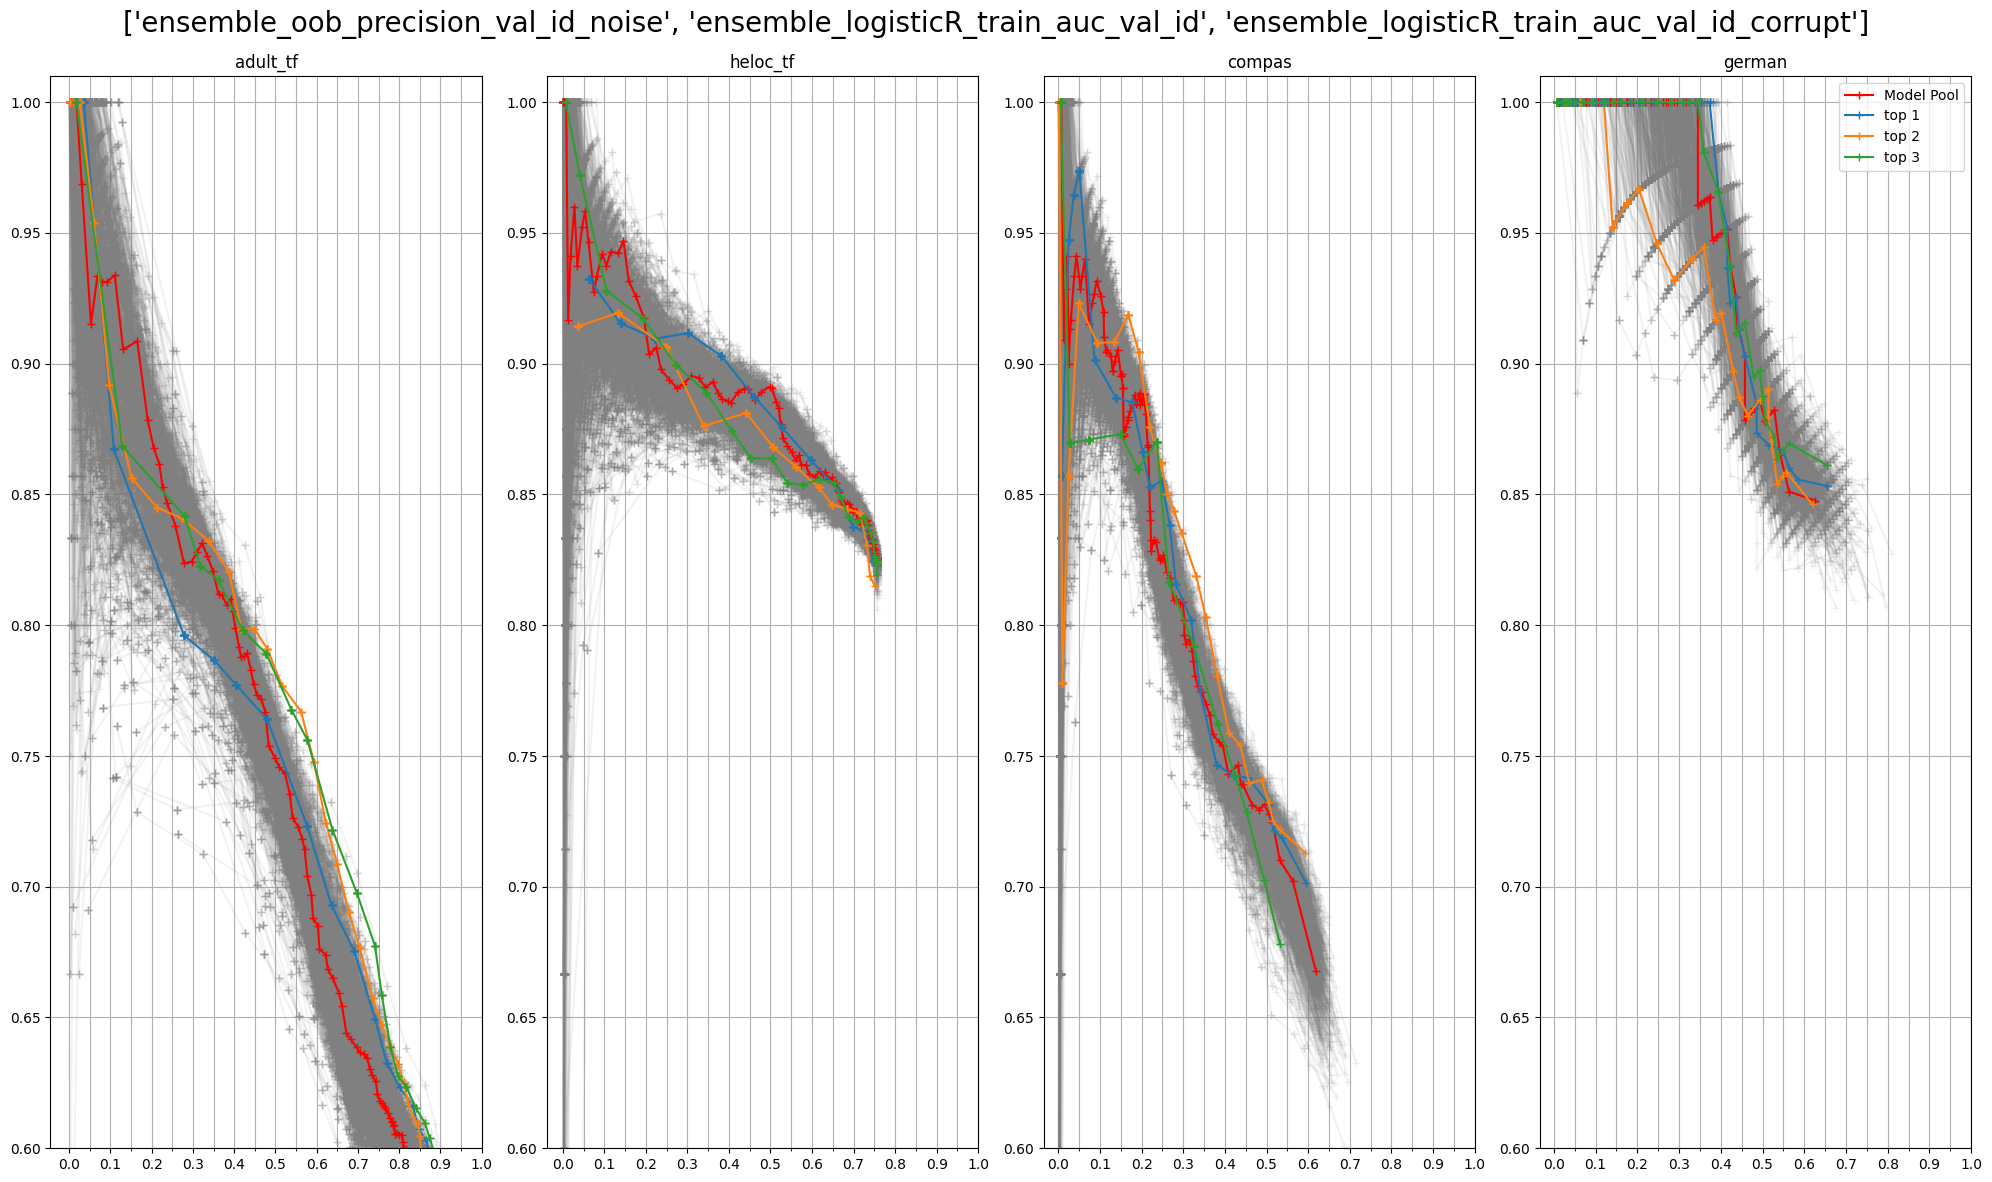

In [35]:
fig, axes = plt.subplots(1, len(datasets), sharey=False, figsize=(20, 12))

for metric, direction in metrics:
    plt.clf()
    fig, axes = plt.subplots(1, len(datasets), sharey=False, figsize=(20, 12))       
    for i, dataset in enumerate(datasets):
        if isinstance(metric, list):
            # take the mean of the list and use that
            dataset_results[dataset]['metric'] = dataset_results[dataset][metric].mean(axis=1).values
            metric_name = 'metric'
        else:
            metric_name = metric
            
        with open(save_path + f'{dataset}/0/model_pool_precision.pkl', 'rb') as file:
            model_pool_precision = pickle.load(file)
        with open(save_path + f'{dataset}/0/model_pool_recall.pkl', 'rb') as file:
            model_pool_recall = pickle.load(file)

        if direction == 'max':
            best_metric = dataset_results[dataset][metric_name].nlargest(top_n).index
        else:
            best_metric = dataset_results[dataset][metric_name].nsmallest(top_n).index
            
        best_fitness_index = {f'top {x+1}':best_metric[x] for x in range(top_n)}


        axes[i] = get_plot(axes[i], 
                           model_pool_precision,
                           model_pool_recall,
                           dataset_recalls[dataset],
                           dataset_precisions[dataset],
                           best_fitness_index,
                           datasets[i])

    plt.legend(loc='best')
    plt.tight_layout(pad=1)
    plt.subplots_adjust(top=0.925) 
    fig.suptitle(metric, fontsize=20)
    plt.show()

### 6. Other
- Get num times different features showed up in evo runs

In [68]:
pd.set_option('display.max_colwidth', None)
three_cols

Unnamed: 0   gen         best_ind  score  \
0              0     0   [528, 664, 31]  0.110   
1              0     1  [663, 672, 519]  0.175   
2              0     2  [663, 672, 519]  0.175   
3              0     3  [522, 264, 519]  0.200   
4              0     4  [522, 329, 519]  0.190   
...          ...   ...              ...    ...   
3272           0  3272  [352, 209, 519]  0.220   
3273           0  3273  [352, 209, 519]  0.220   
3274           0  3274  [352, 209, 519]  0.220   
3275           0  3275  [352, 209, 519]  0.220   
3276           0  3276  [352, 209, 519]  0.220   

                                                                                                                                            best_names  
0                                                   ['incorrect_disagreement_val_id_corrupt', 'ensemble_oob_auc_val_id_noise_diff', 'ensemble_recall']  
1     ['ensemble_oob_recall_val_id_noise_diff', 'ensemble_logisticR_train_precision_val_id_noise_diff', 'ensemble_logisticR_train_auc_val_id_corrupt']  
2     ['ensemble_oob_recall_val_id_noise_diff', 'ensemble_logisticR_train_precision_val_id_noise_diff', 'ensemble_logisticR_train_auc_val_id_corrupt']  
3                ['ensemble_logisticR_val_precision_val_id_corrupt', 'model_conf_agreement_std_val_id', 'ensemble_logisticR_train_auc_val_id_corrupt']  
4                  ['ensemble_logisticR_val_precision_val_id_corrupt', 'min_leaf_samples_val_id_noise', 'ensemble_logisticR_train_auc_val_id_corrupt']  
...                                                                                                                                                ...  
3272                     ['ensemble_oob_precision_val_id_noise', 'ensemble_logisticR_train_auc_val_id', 'ensemble_logisticR_train_auc_val_id_corrupt']  
3273                     ['ensemble_oob_precision_val_id_noise', 'ensemble_logisticR_train_auc_val_id', 'ensemble_logisticR_train_auc_val_id_corrupt']  
3274                     ['ensemble_oob_precision_val_id_noise', 'ensemble_logisticR_train_auc_val_id', 'ensemble_logisticR_train_auc_val_id_corrupt']  
3275                     ['ensemble_oob_precision_val_id_noise', 'ensemble_logisticR_train_auc_val_id', 'ensemble_logisticR_train_auc_val_id_corrupt']  
3276                     ['ensemble_oob_precision_val_id_noise', 'ensemble_logisticR_train_auc_val_id', 'ensemble_logisticR_train_auc_val_id_corrupt']  

[3277 rows x 5 columns]

In [69]:
tmp = three_cols.drop_duplicates(subset='best_ind')
unique_lists = np.array([ast.literal_eval(x) for x in tmp['best_names'].values])
index_counter = Counter(unique_lists.flatten())
index_counter

Counter({'ensemble_logisticR_train_auc_val_id_corrupt': 12,
         'ensemble_logisticR_val_precision_val_id_corrupt': 5,
         'ensemble_logisticR_train_auc_val_id': 5,
         'ensemble_logisticR_train_precision_val_id_noise_diff': 2,
         'ensemble_oob_precision_val_id_noise': 2,
         'incorrect_disagreement_val_id_corrupt': 1,
         'ensemble_oob_auc_val_id_noise_diff': 1,
         'ensemble_recall': 1,
         'ensemble_oob_recall_val_id_noise_diff': 1,
         'model_conf_agreement_std_val_id': 1,
         'min_leaf_samples_val_id_noise': 1,
         'ensemble_logisticR_train_precision_val_id_corrupt': 1,
         'mean_model_confidence_val_id_corrupt': 1,
         'ensemble_both_auc_val_id_corrupt_diff': 1,
         'ensemble_logisticR_val_precision': 1,
         'ensemble_oob_precision': 1,
         'ensemble_logisticR_train_auc_val_id_noise': 1,
         'ensemble_oob_precision_val_id_corrupt': 1})

In [70]:
four_cols

Unnamed: 0   gen              best_ind  score  \
0              0     0  [522, 214, 620, 442]  0.130   
1              0     1   [782, 29, 540, 566]  0.110   
2              0     2   [782, 29, 259, 566]  0.125   
3              0     3   [782, 29, 259, 566]  0.125   
4              0     4   [522, 29, 816, 789]  0.165   
...          ...   ...                   ...    ...   
4465           0  4465  [522, 364, 187, 666]  0.235   
4466           0  4466  [522, 364, 187, 666]  0.235   
4467           0  4467  [522, 364, 187, 666]  0.235   
4468           0  4468  [522, 364, 187, 666]  0.235   
4469           0  4469  [522, 364, 187, 666]  0.235   

                                                                                                                                                          best_names  
0           ['ensemble_logisticR_val_precision_val_id_corrupt', 'ensemble_logisticR_val_auc_val_id', 'mean_training_data_val_id_noise_diff', 'std_mmd_val_id_noise']  
1                 ['max_std_training_data_val_id_corrupt_diff', 'ensemble_acc', 'min_model_percent_positive_val_id_corrupt', 'mean_model_confidence_val_id_corrupt']  
2                               ['max_std_training_data_val_id_corrupt_diff', 'ensemble_acc', 'model_confidence_std_val_id', 'mean_model_confidence_val_id_corrupt']  
3                               ['max_std_training_data_val_id_corrupt_diff', 'ensemble_acc', 'model_confidence_std_val_id', 'mean_model_confidence_val_id_corrupt']  
4                  ['ensemble_logisticR_val_precision_val_id_corrupt', 'ensemble_acc', 'ensemble_oob_acc_val_id_corrupt_diff', 'mean_std_depth_val_id_corrupt_diff']  
...                                                                                                                                                              ...  
4465  ['ensemble_logisticR_val_precision_val_id_corrupt', 'ensemble_logisticR_train_auc_val_id_noise', 'ensemble_auc_val_id', 'ensemble_both_acc_val_id_noise_diff']  
4466  ['ensemble_logisticR_val_precision_val_id_corrupt', 'ensemble_logisticR_train_auc_val_id_noise', 'ensemble_auc_val_id', 'ensemble_both_acc_val_id_noise_diff']  
4467  ['ensemble_logisticR_val_precision_val_id_corrupt', 'ensemble_logisticR_train_auc_val_id_noise', 'ensemble_auc_val_id', 'ensemble_both_acc_val_id_noise_diff']  
4468  ['ensemble_logisticR_val_precision_val_id_corrupt', 'ensemble_logisticR_train_auc_val_id_noise', 'ensemble_auc_val_id', 'ensemble_both_acc_val_id_noise_diff']  
4469  ['ensemble_logisticR_val_precision_val_id_corrupt', 'ensemble_logisticR_train_auc_val_id_noise', 'ensemble_auc_val_id', 'ensemble_both_acc_val_id_noise_diff']  

[4470 rows x 5 columns]

In [71]:
tmp = four_cols.drop_duplicates(subset='best_ind')
unique_lists = np.array([ast.literal_eval(x) for x in tmp['best_names'].values])
index_counter = Counter(unique_lists.flatten())
index_counter

Counter({'ensemble_logisticR_val_precision_val_id_corrupt': 17,
         'ensemble_auc_val_id': 10,
         'ensemble_logisticR_train_auc_val_id_noise': 9,
         'ensemble_logisticR_train_precision_val_id_corrupt': 6,
         'ensemble_acc': 5,
         'ensemble_both_precision_val_id_corrupt': 4,
         'max_std_training_data_val_id_corrupt_diff': 3,
         'mean_std_depth_val_id_corrupt_diff': 3,
         'ensemble_both_acc_val_id_noise_diff': 3,
         'mean_model_confidence_val_id_corrupt': 2,
         'ensemble_oob_acc_val_id_corrupt_diff': 2,
         'ensemble_logisticR_train_acc_val_id_corrupt': 2,
         'ensemble_logisticR_val_precision_val_id_noise': 2,
         'ensemble_oob_acc_val_id_noise_diff': 2,
         'ensemble_logisticR_val_auc_val_id': 1,
         'mean_training_data_val_id_noise_diff': 1,
         'std_mmd_val_id_noise': 1,
         'min_model_percent_positive_val_id_corrupt': 1,
         'model_confidence_std_val_id': 1,
         'median_leaf_sampl